# 引入工具方法 Tools

In [46]:
import torch
import csv
from math import floor, ceil

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def load_from_csv(path):
    with open(path, 'r') as fp:
        source = np.array(list(csv.reader(fp)))[:, :]
    return source


def save_as_csv(path, title, id, pred):
    with open(path, 'w+') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id'] + title)
        for i in range(len(id)):
            writer.writerow([id[i]] + pred[i])

def save_log(path,content):
   with open(path,mode='a+') as fp:
        fp.write(content + '\n')

def split_source(source, tr_indice=0.8):
    source_len = len(source)
    tr_source = source[:floor(source_len * tr_indice), :]
    val_source = source[ceil(source_len * tr_indice):, :]
    return (tr_source, val_source)


def feature_normalization(data: torch.Tensor(), dim):
    return (data - data.mean(dim=dim, keepdim=True)) \
           / data.std(dim=dim, keepdim=True)


def same_seeds(seed=42069):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def plot_learning_curve(record, save_path=None):
    figure(figsize=(6, 4), dpi=100)

    total_steps = len(record['tr_acc'])
    epochs = range(total_steps)

    tr_acc_x, tr_acc_y = epochs, record['tr_acc']
    tr_loss_x, tr_loss_y = epochs, record['tr_loss']
    val_acc_x, val_acc_y = epochs, record['val_acc']
    val_loss_x, val_loss_y = epochs, record['val_loss']

    plt.plot(tr_acc_x, tr_acc_y, c='tab:red', label='train accuracy')
    plt.plot(tr_loss_x, tr_loss_y, c='tab:red', label='train loss', linestyle=":")
    plt.plot(val_acc_x, val_acc_y, c='tab:blue', label='validation accuracy')
    plt.plot(val_loss_x, val_loss_y, c='tab:blue', label='validation loss', linestyle=":")

    plt.ylim(0.0, 5.0)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve')
    plt.legend(loc="upper right")

    plt.grid(alpha=0.3)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    

# 设计模型

## 设计 Dataset

In [47]:
import torch
from torch.utils.data import Dataset

import numpy as np


# design for semi-supervisor
class PseudoSet(Dataset):
    data: tuple()

    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)


class ClassificationSet(Dataset):
    data: list()
    target: list()

    def __init__(self, data, target=None, fn=False):
        self.data = torch.FloatTensor(data.astype(np.float32))
        self.target = torch.LongTensor(target.astype(np.int32)) if target is not None else None

        # feature_normalization
        if fn is True: self.data[:, :] = feature_normalization(self.target[:, :], dim=0)

    def __getitem__(self, item):
        return (self.data[item], self.target[item]) if self.target is not None else self.data[item]

    def __len__(self):
        return len(self.data)


## 设计 Model

In [48]:
import torch
import torch.nn as nn
from torch.nn import Module, Sequential


class ClassificationModel(Module):
    net: Sequential()

    def __init__(self, feature_dim: int, classes_num: int):
        super(ClassificationModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=feature_dim, out_features=732, bias=True),
            nn.Dropout(p=0.5, inplace=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(num_features=732),

            nn.Linear(in_features=732, out_features=classes_num, bias=True)
        )

    def forward(self, data):
        return self.net(data)

    def predict(self, data):
        softmax = nn.Softmax(dim=-1)
        pred = softmax(self.forward(data))
        return pred

# 设计训练

## 半监督学习 Semi-Supervisor

In [49]:
import torch
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader


def do_pseudo(model: Module, dataloader: DataLoader, threshold=0.9, device:str='cpu'):
    append_list = []
    model.eval()
    for data in dataloader:
        with torch.no_grad():
            data = data.to(device)
            pred = torch.max(model.forward(data), dim=1)
            pred_poss = pred[0]
            pred_label = pred[1]
            for index in range(len(data)):
                if pred_poss[index] >= threshold:
                    append_list.append((data[index].cpu(), pred_label[index].cpu()))
    return PseudoSet(data=append_list)

## 监督训练 Train

In [50]:
import torch
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader


def do_train(model: Module, dataloader: DataLoader, optimizer, criterion, device:str='cpu'):
    train_acc = train_loss = 0.0
    model.train()
    for data, target in dataloader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        pred = model.forward(data)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        train_acc += (torch.max(pred, dim=1)[1] == target).sum().cpu().item()
        train_loss += loss.cpu().item()
    train_acc = train_acc / len(dataloader.dataset)
    train_loss = train_loss / len(dataloader)
    return (train_acc, train_loss)

## 模型验证 Validation

In [51]:
import torch
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader


def do_val(model: Module, dataloader: DataLoader, criterion, device:str='cpu'):
    val_acc = val_loss = 0.0
    model.eval()
    if len(dataloader.dataset) > 0:
        for data, target in dataloader:
            with torch.no_grad():
                data, target = data.to(device), target.to(device)
                pred = model.forward(data)
                loss = criterion(pred, target)
            val_acc += (torch.max(pred, dim=1)[1] == target).sum().cpu().item()
            val_loss += loss.cpu().item()
        val_acc = val_acc / len(dataloader.dataset)
        val_loss = val_loss / len(dataloader)
    return val_acc, val_loss

## 模型测试 Test

In [52]:
import torch
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader


def do_test(model: Module, dataloader: DataLoader, device:str='cpu'):
    preds = []
    model.eval()
    for data in dataloader:
        with torch.no_grad():
            data = data.to(device)
            pred = model.predict(data)
        preds.append(pred.detach().cpu())
    return torch.cat(preds, dim=0).numpy().tolist()

# 训练模型

## 引入配置

In [53]:
import torch

params = {
    'project': 'sample',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'source_path': {
        'tr_source_path': './data/train.csv',
        'val_source_path': './data/train.csv',
        'test_source_path': './data/test.csv',
        'pred_path': './data/pred.csv',
        'sample_source_path': './data/sample_submission.csv'
    },
    'model_path': {
        'model_ckpt_path': './model/model-{}.ckpt',
        'model_log_path': './model/model-state.txt',
        'plot_path': './model/model-plot.jpg'
    },
    'classes_number': 99,
    'source_split': 0.9,
    'feature_normalization': True,
    'train_ckpt': False,
    'train_epochs': 300,
    'batch_size': 42,
    'early_stop': True,
    'early_stop_threshold': 20,
    'semi_supervisor': True,
    'semi_supervisor_threshold': 0.95,
    'sgd_param': {
        'learning_rate': 0.005,
        'momentum': 0.9
    },
    'adam_param': {
        'learning_rate': 0.0002,
        'weight_decay': 0.0005
    }
}

## 预读数据

In [54]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset

same_seeds()

label = load_from_csv(params['source_path']['sample_source_path'])[0, 1:].tolist()
source = load_from_csv(params['source_path']['tr_source_path'])[1:, :]

for row in source: row[1] = label.index(row[1])

tr_source, val_source = split_source(source=source, tr_indice=params['source_split'])
test_source = load_from_csv(params['source_path']['test_source_path'])[1:, :]

tr_set = ClassificationSet(data=tr_source[:, 2:], target=tr_source[:, 1])
val_set = ClassificationSet(data=val_source[:, 2:], target=val_source[:, 1])
test_set = ClassificationSet(data=test_source[:, 1:])

## 训练过程

cuda - 001/300 at size 891: tr_acc 0.0236, val_acc 0.0606, tr_loss 4.5844, val_loss 4.5787
cuda - 002/300 at size 891: tr_acc 0.0629, val_acc 0.1717, tr_loss 4.3541, val_loss 4.5097
cuda - 003/300 at size 891: tr_acc 0.1212, val_acc 0.3131, tr_loss 4.1067, val_loss 4.3100
cuda - 004/300 at size 891: tr_acc 0.2256, val_acc 0.4848, tr_loss 3.8890, val_loss 3.9844
cuda - 005/300 at size 891: tr_acc 0.3378, val_acc 0.5354, tr_loss 3.6182, val_loss 3.6287
cuda - 006/300 at size 891: tr_acc 0.4388, val_acc 0.5455, tr_loss 3.3542, val_loss 3.3906
cuda - 007/300 at size 891: tr_acc 0.5297, val_acc 0.5859, tr_loss 3.0849, val_loss 3.1929
cuda - 008/300 at size 891: tr_acc 0.5993, val_acc 0.6263, tr_loss 2.8315, val_loss 2.9775
cuda - 009/300 at size 891: tr_acc 0.6465, val_acc 0.6364, tr_loss 2.5873, val_loss 2.7193
cuda - 010/300 at size 891: tr_acc 0.7160, val_acc 0.7071, tr_loss 2.3551, val_loss 2.4542
cuda - 011/300 at size 891: tr_acc 0.7508, val_acc 0.7677, tr_loss 2.1452, val_loss 2.2246

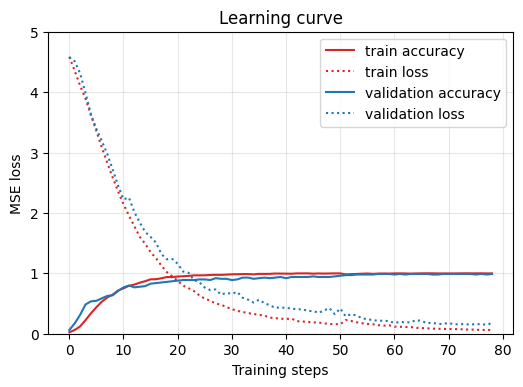

In [55]:
import os

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset


tr_loader = DataLoader(dataset=tr_set, batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=params['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_set, batch_size=params['batch_size'], shuffle=False, pin_memory=True)

criterion = nn.CrossEntropyLoss(reduction='mean').to(params['device'])

model = ClassificationModel(
    feature_dim=len(tr_loader.dataset[0][0]),
    classes_num=len(label)
).to(params['device'])

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=params['adam_param']['learning_rate'],
    weight_decay=params['adam_param']['weight_decay']
)

train_record = {'tr_acc': [], 'tr_loss': [], 'val_acc': [], 'val_loss': []}

perf_acc = perf_loss = 0.0
perf_epoch = 0
early_stop_cnt = 0

for epoch in range(1, int(params['train_epochs']) + 1):

    model_path = params['model_path']['model_ckpt_path'].format(epoch)

    if params['train_ckpt'] is True:
        if os.path.exists(model_path):
            model.load_state_dict(state_dict=torch.load(model_path))
            continue

    if params['semi_supervisor'] is True and perf_acc >= params['semi_supervisor_threshold']:
        pseudo_set = do_pseudo(
            model=model,
            dataloader=test_loader,
            threshold=params['semi_supervisor_threshold'],
            device=params['device']
        )
        tr_loader = DataLoader(
            dataset=ConcatDataset([tr_set, pseudo_set]),
            batch_size=params['batch_size'],
            shuffle=True,
            pin_memory=True
        )

    if params['early_stop'] is True and params['early_stop_threshold'] < early_stop_cnt:
        break

    tr_acc, tr_loss = do_train(
        model=model,
        dataloader=tr_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=params['device']
    )

    val_acc, val_loss = do_val(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=params['device']
    )

    if val_acc > perf_acc:
        perf_epoch, perf_acc, perf_loss = epoch, val_acc, val_loss
        early_stop_cnt = 0
    else:
        early_stop_cnt += 1

    train_record['tr_acc'].append(tr_acc)
    train_record['tr_loss'].append(tr_loss)
    train_record['val_acc'].append(val_acc)
    train_record['val_loss'].append(val_loss)

    log = '{device} - {epoch:03d}/{epochs:3d} at size {size}: ' \
          'tr_acc {tr_acc:.4f}, val_acc {val_acc:.4f}, tr_loss {tr_loss:.4f}, val_loss {val_loss:.4f}'.format(
        size=len(tr_loader.dataset),
        device=params['device'],
        epoch=epoch,
        epochs=params['train_epochs'],
        tr_acc=tr_acc,
        val_acc=val_acc,
        tr_loss=tr_loss,
        val_loss=val_loss
    )
    
    torch.save(model.state_dict(), model_path)
    save_log(params['model_path']['model_log_path'], log)

    print(log)

plot_learning_curve(train_record, save_path=params['model_path']['plot_path'])

## 测试过程

In [56]:
import torch

model_path = params['model_path']['model_ckpt_path'].format(perf_epoch)
model.load_state_dict(torch.load(model_path))

pred_data = do_test(model=model, dataloader=test_loader, device=params['device'])

save_as_csv(
    path=params['source_path']['pred_path'],
    title=label,
    id=test_source[:, 0].tolist(),
    pred=pred_data
)